In [1]:
from utils import *

%load_ext autoreload
%autoreload 2

In [2]:
X_train, y_train, X_test = read_train_test(sentence_per_row_mode=True)

Reading training data ...
Reading training data : Done
Reading testing data ...
Reading testing data : Done


In [343]:
y_train.date_consolidation = y_train.date_consolidation.str.replace("n.a.", "n.c.")

In [3]:
# X_train["text_joined"] = [" ".join(X_train.text[i]) for i in range(X_train.shape[0])]

In [174]:
import unidecode

from nltk.corpus import stopwords
from nltk.stem.snowball import FrenchStemmer

stop_words = set(stopwords.words('french'))
stemmer = FrenchStemmer()

def process_text(text, stem=False):
    """ lowercase, removes stopwords, accents and lemmatizes the tokens if stem=True"""
    text_clean = []
    for sen in text : 
        sen = unidecode.unidecode(sen.replace("’", " ").replace(","," ").replace("."," ").replace(";"," ").lower())
        sen = sen.replace("/ ","/") #some dates are in DD/MM/yyyy format
        tokens = sen.split()
        if stem :
            tokens_no_stpwrd = [stemmer.stem(tok) for tok in tokens if tok not in stop_words]
        else :
#             tokens_no_stpwrd = [tok for tok in tokens if (tok not in stop_words) & (tok.isalnum())]
            tokens_no_stpwrd = [tok for tok in tokens if (tok not in stop_words)]

        no_letters = re.sub(' [a-z] ', " ", " ".join(tokens_no_stpwrd))
        
        text_clean.append(no_letters)

    return text_clean

X_train["text_processed"] = X_train.text.apply(process_text, args=(False,))

In [46]:
X_train.head()

,filename,text,text_processed
ID,,,
0,Agen_100515.txt,"[Le : 12/11/2019, , , Cour d’appel d’Agen , , ...","[, , , cour appel agen, , chambre sociale, , a..."
1,Agen_1100752.txt,"[Le : 12/11/2019, , , Cour d’appel d’Agen , , ...","[, , , cour appel agen, , chambre civile, , au..."
2,Agen_1613.txt,"[Le : 12/11/2019, , , Cour d’appel d’Agen , , ...","[, , , cour appel agen, , audience publique 26..."
3,Agen_2118.txt,"[Le : 12/11/2019, , , Cour d’appel d’Agen , , ...","[, , , cour appel agen, , audience publique 20..."
4,Agen_21229.txt,"[Le : 12/11/2019, , , Cour d’appel d’Agen , , ...","[, , , cour appel agen, , audience publique 22..."


In [4]:
# y_train.loc[X_train[X_train.filename == "Bordeaux_605561.txt"].index]

***

# Extraction du contexte autour de la date (utilisant la target )

In [109]:
def date_parser(date_string):
    """ Transforme une date de YYYY-mm-DD 
        en DD mm (en lettre) YYYY 
        pour la rechercher dans le texte
    """
    
    year_month_day = date_string.split('-')

    list_months=['janvier',"fevrier",
                 'mars','avril','mai','juin','juillet',
                 "aout",'septembre','octobre','novembre',
                 "decembre"]
    
    day = str(int(year_month_day[2])) # sans le 0 qui précède les unités
    month = list_months[int(year_month_day[1])-1]
    year = year_month_day[0]
    
    if day == "1":
        day +="er"
    return day + " " + month + " " + year

In [48]:
def extract_X_sentences_before_after(text, date, X=2):
    """ Va chercher X pharases avant et apres la date passée en param dans le texte
    peut matcher avec plusieurs dates : renvoit toutes ces phrases"""
    try :
        non_capitalized_date = date_parser(date)
    except :
        return "Date NC"
    
    L = np.array([non_capitalized_date in sen for sen in text]) + np.array([non_capitalized_date[:-5] in sen for sen in text])
    
    indexes = []
    
    if np.array(L).any() :
        indexes = np.where(L)[0]
    else :
        return "Pas trouvé de Date sous format DD mm (en lettre) YYYY dans le texte"
    
    result = []
    for ind in indexes :
        result.append(" ".join(text[ind-X : ind+X+1]))
    
    result = [e.replace(non_capitalized_date, "").replace(non_capitalized_date[:-5], '') for e in result]
    return result

import itertools
import igraph
import copy

def terms_to_graph(terms, window_size):
    '''This function returns a directed, weighted igraph from lists of list of terms (the tokens from the pre-processed text)
    e.g., ['quick','brown','fox']
    Edges are weighted based on term co-occurence within a sliding window of fixed size 'w'
    '''
    
    from_to = {}

    w = min(window_size, len(terms))
    # create initial complete graph (first w terms)
    terms_temp = terms[0:w]
    indexes = list(itertools.combinations(range(w), r=2))

    new_edges = []

    for my_tuple in indexes:
        new_edges.append(tuple([terms_temp[i] for i in my_tuple]))
    for new_edge in new_edges:
        if new_edge in from_to:
            from_to[new_edge] += 1
        else:
            from_to[new_edge] = 1

    # then iterate over the remaining terms
    for i in range(w, len(terms)):
        # term to consider
        considered_term = terms[i]
        # all terms within sliding window
        terms_temp = terms[(i - w + 1):(i + 1)]

        # edges to try
        candidate_edges = []
        for p in range(w - 1):
            candidate_edges.append((terms_temp[p], considered_term))

        for try_edge in candidate_edges:

            # if not self-edge
            if try_edge[1] != try_edge[0]:

                # if edge has already been seen, update its weight
                if try_edge in from_to:
                    from_to[try_edge] += 1

                # if edge has never been seen, create it and assign it a unit weight
                else:
                    from_to[try_edge] = 1

    # create empty graph
    g = igraph.Graph(directed=True)

    # add vertices
    g.add_vertices(sorted(set(terms)))

    # add edges, direction is preserved since the graph is directed
    g.add_edges(list(from_to.keys()))

    # set edge and vertice weights
    g.es['weight'] = list(from_to.values()) # based on co-occurence within sliding window
    g.vs['weight'] = g.strength(weights=list(from_to.values())) # weighted degree

    return (g)

def core_dec(g,weighted):
    '''(un)weighted k-core decomposition'''
    # work on clone of g to preserve g 
    gg = copy.deepcopy(g)
    if not weighted:
        gg.vs['weight'] = gg.strength() # overwrite the 'weight' vertex attribute with the unweighted degrees
    # initialize dictionary that will contain the core numbers
    cores_g = dict(zip(gg.vs['name'],[0]*len(gg.vs)))
    
    while len(gg.vs) > 0:
        # find index of lowest degree vertex
        min_degree = min(gg.vs['weight'])
        index_top = gg.vs['weight'].index(min_degree)
        name_top = gg.vs[index_top]['name']
        # get names of its neighbors
        neighbors = gg.vs[gg.neighbors(index_top)]['name']
        # exclude self-edges
        neighbors = [elt for elt in neighbors if elt!=name_top]
        # set core number of lowest degree vertex as its degree
        cores_g[name_top] = min_degree
        # delete top vertex and its incident edges
        gg.delete_vertices(index_top)
        
        if neighbors:
            if weighted: 
                new_degrees = gg.strength(weights=gg.es['weight'])
            else:
                new_degrees = gg.strength()
            # iterate over neighbors of top element
            for neigh in neighbors:
                index_n = gg.vs['name'].index(neigh)
                gg.vs[index_n]['weight'] = max(min_degree,new_degrees[index_n])  
        
    return(cores_g)


In [49]:
context_to_analyse = extract_X_sentences_before_after(X_train.text_processed[20], y_train.date_accident[20], X=1)
context_to_analyse

['acte axa france iard nouvelle denomination sociale place compagnie assurances jugement defere reconnu droit philippe indemnisation integrale prejudice suite accident  surplus jugement defere statuant nouveau',
 'incidence professionnelle temporaire attendu evaluer incidence professionnelle temporaire periode  10 juin 1999 arret mixte precite demande expert judiciaire calculer montant prejudice nature economique effectivement subi philippe compte tenu revenus professionnels anterieurs a attendu expert precise rapport revenu professionnel philippe anterieurement accident correspond benefice net fiscal annuel realise cadre exploitation fonds commerce salon the situe menton acquis 16 mai',
 'attendu toutefois expert indique 000 subie vente fonds commerce realisee 29 octobre 1999 consequence chute constante chiffre affaires patisserie depuis accident  cette baisse representant chiffre affaire exercice 1994 exercice complet avant rapport dernier exercice clos avant baisse chiffre affaires 

In [10]:
y_train.iloc[4]

sexe                       homme
date_accident         1996-11-26
date_consolidation          n.c.
Name: 4, dtype: object

In [9]:
# g = terms_to_graph(words.split(" "), 4)
# dico = core_dec(g, True)
# dico

# Contexte autour de la date d':

In [478]:
terms_discarding_the_date = ["loi",
                             "jugement",
                             "audience",
                             "publique",
                             "tribubal",
                             "decision",
                             "greffe",
                             "ordonnance",
                             ]
def extract_X_sentences_around_all_dates(text, terms_discarding_the_date=terms_discarding_the_date, 
                                         use_date_forcing=False, date_to_look_for=None,
                                         X=1):
    """
    The text in structured format ( like in the column text of X_train)
    - Looks for all the dates in the text
    - for each date, extract X sentences  before and after this date (sentence meaning rows of the original doc)
    - if a row has multiple dates, separate each date in a row (the dates will have the same context) ==> PROBLEM7
    - remove the contexts taht contain the words in terms_discarding_the_date (meaning that those are probably other dates) ==> Build a classifier 3 classes after
    - Return a list of tuples (context in lower + no stopwords + clean from punct , date)
    - this context can be passed to Spacy avg vectorizer to get the avg Word embedding of the sentence
    """
    if use_date_forcing :
        assert date_to_look_for is not None
        try :
            date = date_parser(date_to_look_for)
        except :
            return "Date NC"
        
        l = [re.findall(date, STRING) if (re.findall(date, STRING)!=[]) else re.findall(date[:-5], STRING) for STRING in text ] 
        indexes = [i for i in range(len(l)) if len(l[i])!=0]
        ll = [(" ".join(text[i-X+1 : i+X]), l[i]) for i in indexes]
        
        lll = []
        for i in range(len(ll)) :
            if len([word for word in terms_discarding_the_date if word in ll[i][0]]) == 0 :
                if len(ll[i][1]) == 1 :
                    date = ll[i][1][0]
                    context_date_removed = ll[i][0].replace(date, '')
                    context_date_removed_cleaned = ""
                    for element in context_date_removed :
                        if not element.isalnum():
                            if element == " " :
                                context_date_removed_cleaned += element 
                        else :
                            context_date_removed_cleaned += element 
                    lll.append((context_date_removed_cleaned, date))
                else :
                    for j in range(len(ll[i][1])) :
                        date = ll[i][1][j]
                        context_date_removed = ll[i][0].replace(date, '')
                        context_date_removed_cleaned = ''
                        for element in context_date_removed :
                            if not element.isalnum():
                                if element == " " :
                                    context_date_removed_cleaned += element 
                            else :
                                context_date_removed_cleaned += element 
                        lll.append((context_date_removed_cleaned, date))
    else :
        l = [re.findall("\d{1,2} [a-zéû]{3,9} \d{4}", STRING) for STRING in text]
        indexes = [i for i in range(len(l)) if len(l[i])!=0]
        ll = [(" ".join(text[i-X+1 : i+X]), l[i]) for i in indexes]
        lll = []
        for i in range(len(ll)) :
            if len([word for word in terms_discarding_the_date if word in ll[i][0]]) == 0 :
                if len(ll[i][1]) == 1 :
                    date = ll[i][1][0]
                    context_date_removed = ll[i][0].replace(date, '')
                    if context_date_removed != "": 
                        lll.append((context_date_removed, date))
                else :
                    for j in range(len(ll[i][1])) :
                        date = ll[i][1][j]
                        context_date_removed = ll[i][0].replace(date, '')
                        if context_date_removed != "": 
                            lll.append((context_date_removed, date))
    return lll

In [288]:
# terms_discarding_the_date = ["loi",
#                              "jugement",
#                              "audience",
#                              "publique",
#                              "juge",
#                              "tribubal",
#                              "decision",
#                              "greffe",
#                              "conclusion",
#                              "ordonnance",
#                              ]

# def extract_X_sentences_around_all_dates(text, terms_discarding_the_date, X=1):
#     """
#     The text in structured format ( like in the column text of X_train)
#     - Looks for all the dates in the text
#     - for each date, extract X sentences  before and after this date (sentence meaning rows of the original doc)
#     - if a row has multiple dates, separate each date in a row (the dates will have the same context) ==> PROBLEM
#     - Return a list of tuples (context in lower + no stopwords + clean from punct , date)
#     - this context can be passed to Spacy avg vectorizer to get the avg Word embedding of the sentence
#     """
#     l = [re.findall("\d{1,2} [a-zéû]{3,9} \d{4}", STRING) for STRING in text]
#     indexes = [i for i in range(len(l)) if len(l[i])!=0]
#     ll = [(" ".join(text[i-X+1 : i+X]), l[i]) for i in indexes]
    
    
#     lll = []
#     for i in range(len(ll)) :
#         if len([word for word in terms_discarding_the_date if word in ll[i][0]]) == 0 :
#             if len(ll[i][1]) == 1 :
#                 date = ll[i][1][0]
#                 context_date_removed = ll[i][0].replace(date, '')
#                 lll.append((context_date_removed, date))
#             else :
#                 for j in range(len(ll[i][1])) :

#                     date = ll[i][1][j]
#                     context_date_removed = ll[i][0].replace(date, '')
#                     lll.append((context_date_removed, date))
#     return lll

## Accident

In [447]:
L = []
for i in range(X_train.shape[0]) :
#     context_to_analyse = extract_X_sentences_before_after(X_train.text_processed[i], y_train.date_accident[i], X=1)
    context_to_analyse = extract_X_sentences_around_all_dates(X_train.text_processed.iloc[i], 
                                                              terms_discarding_the_date, 
                                                              use_date_forcing=True,
                                                              date_to_look_for=y_train.date_accident.iloc[i])
    if (context_to_analyse == []) or context_to_analyse == "Date NC" :
        L.append(None)
#     if context_to_analyse in ["Pas trouvé de Date sous format DD mm (en lettre) YYYY dans le texte", "Date NC"] :
#         L.append(context_to_analyse)
    else :
        L.append(context_to_analyse[0][0]) # je ne prends que le premier contexte pour commencer
#         L.append(" ".join(context_to_analyse))
X_train["context_around_accident"] = L

In [302]:
# L = []
# for i in range(X_train.shape[0]) :
#     text = X_train.context_around_accident[i]
#     if text in ["Pas trouvé de Date sous format DD mm (en lettre) YYYY dans le texte", "Date NC"] :
#         L.append(None)
#     else :
#         L.append(text)
# X_train["context_around_accident_processed"] = L

## Consolidation

In [448]:
L = []
for i in range(X_train.shape[0]) :
#     context_to_analyse = extract_X_sentences_before_after(X_train.text_processed[i], y_train.date_consolidation[i], X=1)
#     if context_to_analyse in ["Pas trouvé de Date sous format DD mm (en lettre) YYYY dans le texte", "Date NC"] :
#         L.append(context_to_analyse)
    context_to_analyse = extract_X_sentences_around_all_dates(X_train.text_processed.iloc[i], 
                                                              terms_discarding_the_date, 
                                                              use_date_forcing=True,
                                                              date_to_look_for=y_train.date_consolidation.iloc[i])
    if (context_to_analyse == []) or context_to_analyse == "Date NC" :
        L.append(None)
    else :
        L.append(context_to_analyse[0][0]) # je ne prends que le premier contexte pour commencer
#         L.append(" ".join(context_to_analyse))
X_train["context_around_consolidation"] = L

In [399]:
# L = []
# for i in range(X_train.shape[0]) :
#     text = X_train.context_around_consolidation[i]
#     if text in ["Pas trouvé de Date sous format DD mm (en lettre) YYYY dans le texte", "Date NC"] :
#         L.append(None)
#     else :
#         L.append(text)
# X_train["context_around_consolidation_processed"] = L

## Spacy word vectors

In [305]:
import fr_core_news_md
nlp = fr_core_news_md.load()

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [306]:
from fuzzywuzzy import process

def letter_date_to_submission_date(string) :
    
    dico_months = {"janvier" : "01",
               'fevrier' : "02",
               "mars" : "03",
               "avril" : "04",
               "mai" : "05",
               "juin" : "06",
               "juillet" : "07",
               "aout" : "08",
                "septembre" : "09",
               "octobre": '10',
               "novembre" : "11",
               "decembre":'12'}
    
    strings = string.split()
    
    if len(strings[0]) == 1 :
        day = "0"+strings[0]
    else :
        day = strings[0]
        
    month = process.extract(strings[1], dico_months.keys())[0][0]
    return strings[2]+"-"+dico_months[month]+"-"+day

d:\anaconda\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


To asses the performance of our model that predicts if the context around a date is talking about `date d'accident` or `date de consolidation` :

- Take split X_train using train_test_split into X_tr and X_te
- Prepare data for model fitting :
    - For date d'accident : 
        - remove the dates from the accident contexts of X_tr
        - remove the punctuation from the accident contexts of X_tr
        - remove the stopwords from the accident contexts of X_tr  
        - use Spacy avg vectorizer or tfidf
    - Same thing for date de conso
    - concatenate the two 
    - fit two models : one to predict accident contexts and the other the consolidation contexts
- On X_te :
    - On each text apply the function extract `X_sentences_around_all_dates`
    - for each sentence apply the Spacy vectorizer and predict using the models
    - predict the date of which the context gave the higher probability score.

Results : 
- accident : 35% accuracy with tf idf approach on context extracted with X=1 and SVM classifier
- conso : 24% accuracy with spacy word vectors approach on context extracted with X=1 and SVM classifier

In [345]:
X_tr, X_te = train_test_split(X_train, random_state=50)

<IPython.core.display.Javascript object>

In [346]:
# train_accident_context_avg_WV = np.array([
#     nlp(sen).vector for sen in X_tr.context_around_accident_processed if sen is not None ])

# train_consolidation_context_avg_WV = np.array([
#     nlp(sen).vector for sen in X_tr.context_around_consolidation_processed if sen is not None ])

train_accident_context_avg_WV = np.array([
    nlp(sen).vector for sen in X_tr.context_around_accident if sen is not None ])

train_consolidation_context_avg_WV = np.array([
    nlp(sen).vector for sen in X_tr.context_around_consolidation if sen is not None ])


 
is_accident = [1 for _ in range(train_accident_context_avg_WV.shape[0])]
is_not_accident = [0 for _ in range(train_consolidation_context_avg_WV.shape[0])]
data = np.concatenate((train_accident_context_avg_WV, train_consolidation_context_avg_WV))
target = np.concatenate((is_accident, is_not_accident))

# clf_accident = LogisticRegression().fit(data, target)
clf_accident = SVC(gamma='auto', probability=True).fit(data, target)

###############################################

is_conso = [1 for _ in range(train_consolidation_context_avg_WV.shape[0])]
is_not_conso = [0 for _ in range(train_accident_context_avg_WV.shape[0])]
data = np.concatenate((train_consolidation_context_avg_WV, train_accident_context_avg_WV))
target = np.concatenate((is_conso, is_not_conso))

# clf_conso = LogisticRegression().fit(data, target)
clf_conso = SVC(gamma='auto', probability=True).fit(data, target)

In [364]:
len(train_accident_context_avg_WV), len(train_consolidation_context_avg_WV)

(524, 300)

In [347]:
# index_not_none_accident = [ind for ind in X_te.index if X_te.context_around_accident_processed.loc[ind] is not None]
# index_not_none_conso = [ind for ind in X_te.index if X_te.context_around_consolidation_processed.loc[ind] is not None]

index_not_none_accident = [ind for ind in X_te.index if X_te.context_around_accident.loc[ind] is not None]
index_not_none_conso = [ind for ind in X_te.index if X_te.context_around_consolidation.loc[ind] is not None]


y_true_accident = y_train.loc[index_not_none_accident].date_accident.values
y_true_consolidation = y_train.loc[index_not_none_conso].date_consolidation.values

y_pred_accident = {}
y_pred_conso = {}

for i in X_te.index :
    
    use_acccident_model = False
    use_conso_model = False
    
    if i in index_not_none_accident :
        use_acccident_model = True
        
    if i in index_not_none_conso :
        use_conso_model = True
    
    sentences_to_test = extract_X_sentences_around_all_dates(X_te.text_processed.loc[i], terms_discarding_the_date)
    
    probas_accident = []
    probas_conso = []
    
    if use_acccident_model & use_conso_model :
        for tup in sentences_to_test :
            processed_sentence = tup[0]
            WV_processed_sentence = nlp(processed_sentence).vector
            probas_accident.append(clf_accident.predict_proba([WV_processed_sentence]))
            probas_conso.append(clf_conso.predict_proba([WV_processed_sentence]))
    elif use_acccident_model : 
        for tup in sentences_to_test :
            processed_sentence = tup[0]
            WV_processed_sentence = nlp(processed_sentence).vector
            probas_accident.append(clf_accident.predict_proba([WV_processed_sentence]))
    elif use_conso_model :
        for tup in sentences_to_test :
            processed_sentence = tup[0]
            WV_processed_sentence = nlp(processed_sentence).vector
            probas_conso.append(clf_conso.predict_proba([WV_processed_sentence]))
    else :
        pass
            
    threshold_accident = 0.7
    threshold_conso = 0.7    

    if use_acccident_model :
        probas_accident = np.squeeze(probas_accident)[:,1]
        if probas_accident.max() >= threshold_accident :
            y_pred_accident[i] = letter_date_to_submission_date(sentences_to_test[np.argmax(probas_accident)][1])
        else :
            y_pred_accident[i] = "n.c."
            
    if use_conso_model :
        probas_conso = np.squeeze(probas_conso)[:,1]
        if probas_conso.max() >= threshold_conso :
            y_pred_conso[i] = letter_date_to_submission_date(sentences_to_test[np.argmax(probas_conso)][1])
        else :
            y_pred_conso[i] = "n.c."
    

In [348]:
(y_true_accident == np.array(list(y_pred_accident.values()))).mean()

0.5535714285714286

In [349]:
(y_true_consolidation == np.array(list(y_pred_conso.values()))).mean()

0.5252525252525253

In [319]:
i = np.random.choice(X_te.index)

y_true_accident_ = dict(y_train.loc[index_not_none_accident].date_accident)
y_true_consolidation_ = dict(y_train.loc[index_not_none_conso].date_consolidation)


use_acccident_model = False
use_conso_model = False

if i in index_not_none_accident :
    use_acccident_model = True

if i in index_not_none_conso :
    use_conso_model = True

sentences_to_test = extract_X_sentences_around_all_dates(X_te.text_processed.loc[i], terms_discarding_the_date)

probas_accident = []
probas_conso = []

if use_acccident_model & use_conso_model :
    for tup in sentences_to_test :
        processed_sentence = tup[0]
        WV_processed_sentence = nlp(processed_sentence).vector
        probas_accident.append(clf_accident.predict_proba([WV_processed_sentence]))
        probas_conso.append(clf_conso.predict_proba([WV_processed_sentence]))
elif use_acccident_model : 
    for tup in sentences_to_test :
        processed_sentence = tup[0]
        WV_processed_sentence = nlp(processed_sentence).vector
        probas_accident.append(clf_accident.predict_proba([WV_processed_sentence]))
elif use_conso_model :
    for tup in sentences_to_test :
        processed_sentence = tup[0]
        WV_processed_sentence = nlp(processed_sentence).vector
        probas_conso.append(clf_conso.predict_proba([WV_processed_sentence]))

threshold_accident = 0.7
threshold_conso = 0.7    

if use_acccident_model :
    probas_accident = np.squeeze(probas_accident)[:,1]
    print(sentences_to_test[np.argmax(probas_accident)], probas_accident.max(), dict(y_true_accident_)[i])
    plt.title("probas of accident date context of the index {}".format(i))
    plt.bar(range(probas_accident.shape[0]), probas_accident);
    plt.show()
if use_conso_model :
    probas_conso = np.squeeze(probas_conso)[:,1]
    print(sentences_to_test[np.argmax(probas_conso)], probas_conso.max(), dict(y_true_consolidation_)[i])
    plt.title("probas of consolidation date context of the index {}".format(i))
    plt.bar(range(probas_conso.shape[0]), probas_conso);

('compagnie assurances generali procede reglement cette somme ', '17 fevrier 2012') 0.8737924124133967 2005-03-05


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 1 Axes>

('- date consolidation : ', '31 janvier 2009') 0.9999999887316658 2009-01-31


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Tf idf approach

In [320]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [351]:
# train_accident_corpus = [sen for sen in X_tr.context_around_accident_processed if sen is not None ]
# train_consolidation_corpus = [sen for sen in X_tr.context_around_consolidation_processed if sen is not None ]

train_accident_corpus = [sen for sen in X_tr.context_around_accident if sen is not None ]
train_consolidation_corpus = [sen for sen in X_tr.context_around_consolidation if sen is not None ]

data = np.concatenate((train_accident_corpus, train_consolidation_corpus))
vectorizer = TfidfVectorizer()
data_tfidf = vectorizer.fit_transform(data)


is_accident = [1 for _ in range(len(train_accident_corpus))]
is_not_accident = [0 for _ in range(len(train_consolidation_corpus))]
target = np.concatenate((is_accident, is_not_accident))
# clf_accident = LogisticRegression().fit(data, target)
clf_accident = SVC(gamma='auto', probability=True).fit(data_tfidf, target)


###############################################

is_conso = [1 for _ in range(len(train_accident_corpus))]
is_not_conso = [0 for _ in range(len(train_consolidation_corpus))]
data = np.concatenate((train_consolidation_corpus, train_accident_corpus))
target = np.concatenate((is_conso, is_not_conso))
# clf_conso = LogisticRegression().fit(data, target)
clf_conso = SVC(gamma='auto', probability=True).fit(data_tfidf, target)


In [356]:
# index_not_none_accident = [ind for ind in X_te.index if X_te.context_around_accident_processed.loc[ind] is not None]
# index_not_none_conso = [ind for ind in X_te.index if X_te.context_around_consolidation_processed.loc[ind] is not None]

index_not_none_accident = [ind for ind in X_te.index if X_te.context_around_accident.loc[ind] is not None]
index_not_none_conso = [ind for ind in X_te.index if X_te.context_around_consolidation.loc[ind] is not None]


y_true_accident = y_train.loc[index_not_none_accident].date_accident.values
y_true_consolidation = y_train.loc[index_not_none_conso].date_consolidation.values

y_pred_accident = {}
y_pred_conso = {}

for i in X_te.index :
    
    use_acccident_model = False
    use_conso_model = False
    
    if i in index_not_none_accident :
        use_acccident_model = True
        
    if i in index_not_none_conso :
        use_conso_model = True
    
    sentences_to_test = extract_X_sentences_around_all_dates(X_te.text_processed.loc[i], terms_discarding_the_date)
    
    probas_accident = []
    probas_conso = []
    
    if use_acccident_model & use_conso_model :
        for tup in sentences_to_test :
            processed_sentence = tup[0]
            WV_processed_sentence = nlp(processed_sentence).vector
            tfidf_encoded_processed_sentence = vectorizer.transform([processed_sentence])
            probas_accident.append(clf_accident.predict_proba(tfidf_encoded_processed_sentence))
            probas_conso.append(clf_conso.predict_proba(tfidf_encoded_processed_sentence))
            
    elif use_acccident_model : 
        for tup in sentences_to_test :
            processed_sentence = tup[0]
            WV_processed_sentence = nlp(processed_sentence).vector
            tfidf_encoded_processed_sentence = vectorizer.transform([processed_sentence])
            probas_accident.append(clf_accident.predict_proba(tfidf_encoded_processed_sentence))
    elif use_conso_model :
        for tup in sentences_to_test :
            processed_sentence = tup[0]
            WV_processed_sentence = nlp(processed_sentence).vector
            tfidf_encoded_processed_sentence = vectorizer.transform([processed_sentence])
            probas_conso.append(clf_conso.predict_proba(tfidf_encoded_processed_sentence))
    else :
        pass
            
    threshold_accident = 0.7
    threshold_conso = 0.8

    if use_acccident_model :
        probas_accident = np.squeeze(probas_accident)[:,1]
        if probas_accident.max() >= threshold_accident :
            y_pred_accident[i] = letter_date_to_submission_date(sentences_to_test[np.argmax(probas_accident)][1])
        else :
            y_pred_accident[i] = "n.c."
            
    if use_conso_model :
        probas_conso = np.squeeze(probas_conso)[:,1]
        if probas_conso.max() >= threshold_conso :
            y_pred_conso[i] = letter_date_to_submission_date(sentences_to_test[np.argmax(probas_conso)][1])
        else :
            y_pred_conso[i] = "n.c."
    

In [358]:
(y_true_accident == np.array(list(y_pred_accident.values()))).mean()

0.6607142857142857

In [357]:
(y_true_consolidation == np.array(list(y_pred_conso.values()))).mean()

0.010101010101010102

(' monsieur pierre circulait motocyclette rn 193 sens ponte leccia-corte (haute corse) ete victime grave accident circulation impliquant vehicule location appartenant holcar assure aupres covea fleet conduit monsieur gerhard h', '21 aout 2003') 0.9443406278082515 2003-08-21


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

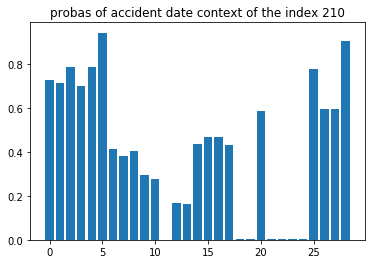

(' monsieur pierre circulait motocyclette rn 193 sens ponte leccia-corte (haute corse) ete victime grave accident circulation impliquant vehicule location appartenant holcar assure aupres covea fleet conduit monsieur gerhard h', '21 aout 2003') 0.9423745951042248 2005-08-21


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

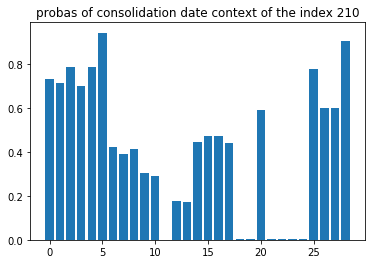

In [331]:
i = np.random.choice(X_te.index)

y_true_accident_ = dict(y_train.loc[index_not_none_accident].date_accident)
y_true_consolidation_ = dict(y_train.loc[index_not_none_conso].date_consolidation)

use_acccident_model = False
use_conso_model = False

if i in index_not_none_accident :
    use_acccident_model = True

if i in index_not_none_conso :
    use_conso_model = True

sentences_to_test = extract_X_sentences_around_all_dates(X_te.text_processed.loc[i], terms_discarding_the_date)

probas_accident = []
probas_conso = []

if use_acccident_model & use_conso_model :
    for tup in sentences_to_test :
        processed_sentence = tup[0]
        WV_processed_sentence = nlp(processed_sentence).vector
        tfidf_encoded_processed_sentence = vectorizer.transform([processed_sentence])
        probas_accident.append(clf_accident.predict_proba(tfidf_encoded_processed_sentence))
        probas_conso.append(clf_conso.predict_proba(tfidf_encoded_processed_sentence))

elif use_acccident_model : 
    for tup in sentences_to_test :
        processed_sentence = tup[0]
        WV_processed_sentence = nlp(processed_sentence).vector
        tfidf_encoded_processed_sentence = vectorizer.transform([processed_sentence])
        probas_accident.append(clf_accident.predict_proba(tfidf_encoded_processed_sentence))
elif use_conso_model :
    for tup in sentences_to_test :
        processed_sentence = tup[0]
        WV_processed_sentence = nlp(processed_sentence).vector
        tfidf_encoded_processed_sentence = vectorizer.transform([processed_sentence])
        probas_conso.append(clf_conso.predict_proba(tfidf_encoded_processed_sentence))
else :
    pass

threshold_accident = 0.7
threshold_conso = 0.7    

if use_acccident_model :
    probas_accident = np.squeeze(probas_accident)[:,1]
    print(sentences_to_test[np.argmax(probas_accident)], probas_accident.max(), dict(y_true_accident_)[i])
    plt.title("probas of accident date context of the index {}".format(i))
    plt.bar(range(probas_accident.shape[0]), probas_accident);
    plt.show()
if use_conso_model :
    probas_conso = np.squeeze(probas_conso)[:,1]
    print(sentences_to_test[np.argmax(probas_conso)], probas_conso.max(), dict(y_true_consolidation_)[i])
    plt.title("probas of consolidation date context of the index {}".format(i))
    plt.bar(range(probas_conso.shape[0]), probas_conso);

# Three classes approach 

In [444]:
terms_discarding_the_date = ["loi",
                             "jugement",
                             "audience",
                             "publique",
#                              "juge",
                             "tribubal",
                             "decision",
                             "greffe",
                             "conclusion",
                             "ordonnance",
                             ]
def extract_X_sentences_around_all_dates_other_dates(text, terms_discarding_the_date= terms_discarding_the_date, 
                                                     X=1):
    """
    The text in structured format ( like in the column text of X_train)
    - Looks for all the dates in the text
    - for each date, extract X sentences  before and after this date (sentence meaning rows of the original doc)
    - if a row has multiple dates, separate each date in a row (the dates will have the same context) ==> PROBLEM7
    - remove the contexts taht contain the words in terms_discarding_the_date (meaning that those are probably other dates) ==> Build a classifier 3 classes after
    - Return a list of tuples (context in lower + no stopwords + clean from punct , date)
    - this context can be passed to Spacy avg vectorizer to get the avg Word embedding of the sentence
    """

    l = [re.findall("\d{1,2} [a-zéû]{3,9} \d{4}", STRING) for STRING in text]
    indexes = [i for i in range(len(l)) if len(l[i])!=0]
    ll = [(" ".join(text[i-X+1 : i+X]), l[i]) for i in indexes]

    lll = []
    for i in range(len(ll)) :
        if len([word for word in terms_discarding_the_date if word in ll[i][0]]) > 0 :
            if len(ll[i][1]) == 1 :
                date = ll[i][1][0]
                context_date_removed = ll[i][0].replace(date, '')
                lll.append((context_date_removed, date))
    ind = np.random.choice(range(len(lll))) # je ne prends qu'un contexte aleatoirement pour commencer
    return lll[ind][0]

## Autre dates

In [445]:
L = []
for i in range(X_train.shape[0]) :
    context_to_analyse = extract_X_sentences_around_all_dates_other_dates(X_train.text_processed.iloc[i])
    
    context_to_analyse_cleaned = ""
    for element in context_to_analyse :
        if not element.isalnum():
            if element == " " :
                context_to_analyse_cleaned += element 
        else :
            context_to_analyse_cleaned += element 
    L.append(context_to_analyse_cleaned)
    
X_train["context_around_autre_date_random"] = L

In [449]:
X_tr, X_te = train_test_split(X_train, random_state=50)

<IPython.core.display.Javascript object>

## Word vectors approach

In [450]:
train_accident_context_avg_WV = np.array([
    nlp(sen).vector for sen in X_tr.context_around_accident if sen is not None ])

train_consolidation_context_avg_WV = np.array([
    nlp(sen).vector for sen in X_tr.context_around_consolidation if sen is not None ])

train_other_context_avg_WV = np.array([
    nlp(sen).vector for sen in X_tr.context_around_autre_date_random if sen is not None ])

data = np.concatenate((train_accident_context_avg_WV, train_consolidation_context_avg_WV, train_other_context_avg_WV))

is_accident = [0 for _ in range(train_accident_context_avg_WV.shape[0])]
is_condo = [1 for _ in range(train_consolidation_context_avg_WV.shape[0])]
is_other = [2 for _ in range(train_other_context_avg_WV.shape[0])]

target = np.concatenate((is_accident, is_condo, is_other))

# # clf_accident = LogisticRegression().fit(data, target)
clf = SVC(gamma='auto', probability=True).fit(data, target)


In [487]:
index_not_none_accident = [ind for ind in X_te.index if X_te.context_around_accident.loc[ind] is not None]
index_not_none_conso = [ind for ind in X_te.index if X_te.context_around_consolidation.loc[ind] is not None]


y_true_accident = y_train.loc[index_not_none_accident].date_accident.values
y_true_consolidation = y_train.loc[index_not_none_conso].date_consolidation.values

y_pred_accident = {}
y_pred_conso = {}

for i in X_te.index :
    
    if (i in index_not_none_accident) & (i in index_not_none_conso) :
        
        sentences_to_test = extract_X_sentences_around_all_dates(X_te.text_processed.loc[i], [])
    
        probas_predictions = []
        for tup in sentences_to_test :
            processed_sentence = tup[0]
            WV_processed_sentence = nlp(processed_sentence).vector
            probas_predictions.append(clf.predict_proba([WV_processed_sentence]))
        probas_predictions = np.squeeze(probas_predictions)

        ind_accident = np.argmax(probas_predictions[:,0])
        ind_conso = np.argmax(probas_predictions[:,1])    
    
        y_pred_accident[i] = letter_date_to_submission_date(sentences_to_test[ind_accident][1])
        y_pred_conso[i] = letter_date_to_submission_date(sentences_to_test[ind_conso][1]) 
        
    elif i in index_not_none_accident :
        sentences_to_test = extract_X_sentences_around_all_dates(X_te.text_processed.loc[i], [])
        probas_predictions = []
        for tup in sentences_to_test :
            processed_sentence = tup[0]
            WV_processed_sentence = nlp(processed_sentence).vector
            probas_predictions.append(clf.predict_proba([WV_processed_sentence]))
        probas_predictions = np.squeeze(probas_predictions)

        ind_accident = np.argmax(probas_predictions[:,0])    
        y_pred_accident[i] = letter_date_to_submission_date(sentences_to_test[ind_accident][1])
    
    
    elif i in index_not_none_conso :
        sentences_to_test = extract_X_sentences_around_all_dates(X_te.text_processed.loc[i], [])
        probas_predictions = []
        for tup in sentences_to_test :
            processed_sentence = tup[0]
            WV_processed_sentence = nlp(processed_sentence).vector
            probas_predictions.append(clf.predict_proba([WV_processed_sentence]))
        probas_predictions = np.squeeze(probas_predictions)

        ind_conso = np.argmax(probas_predictions[:,1])   
        y_pred_conso[i] = letter_date_to_submission_date(sentences_to_test[ind_conso][1]) 
    

In [488]:
(y_true_accident == np.array(list(y_pred_accident.values()))).mean()

0.6190476190476191

In [489]:
(y_true_consolidation == np.array(list(y_pred_conso.values()))).mean()

0.57

## Tf idf approach

In [492]:
train_accident_corpus = [sen for sen in X_tr.context_around_accident if sen is not None ]
train_consolidation_corpus = [sen for sen in X_tr.context_around_consolidation if sen is not None ]
train_other_context_corpus = [sen for sen in X_tr.context_around_autre_date_random if sen is not None]

data = np.concatenate((train_accident_corpus, train_consolidation_corpus, train_other_context_corpus))
vectorizer = TfidfVectorizer()
data_tfidf = vectorizer.fit_transform(data)

is_accident = [0 for _ in range(len(train_accident_corpus))]
is_condo = [1 for _ in range(len(train_consolidation_corpus))]
is_other = [2 for _ in range(len(train_other_context_corpus))]

target = np.concatenate((is_accident, is_condo, is_other))

clf = SVC(gamma='auto', probability=True).fit(data_tfidf, target)

In [496]:
index_not_none_accident = [ind for ind in X_te.index if X_te.context_around_accident.loc[ind] is not None]
index_not_none_conso = [ind for ind in X_te.index if X_te.context_around_consolidation.loc[ind] is not None]


y_true_accident = y_train.loc[index_not_none_accident].date_accident.values
y_true_consolidation = y_train.loc[index_not_none_conso].date_consolidation.values

y_pred_accident = {}
y_pred_conso = {}

for i in X_te.index :
    
    if (i in index_not_none_accident) & (i in index_not_none_conso) :
        
        sentences_to_test = extract_X_sentences_around_all_dates(X_te.text_processed.loc[i], [])
    
        probas_predictions = []
        for tup in sentences_to_test :
            processed_sentence = tup[0]
            tfidf_processed_sentence = vectorizer.transform([processed_sentence])
            probas_predictions.append(clf.predict_proba(tfidf_processed_sentence))
        probas_predictions = np.squeeze(probas_predictions)

        ind_accident = np.argmax(probas_predictions[:,0])
        ind_conso = np.argmax(probas_predictions[:,1])    
    
        y_pred_accident[i] = letter_date_to_submission_date(sentences_to_test[ind_accident][1])
        y_pred_conso[i] = letter_date_to_submission_date(sentences_to_test[ind_conso][1]) 
        
    elif i in index_not_none_accident :
        sentences_to_test = extract_X_sentences_around_all_dates(X_te.text_processed.loc[i], [])
        probas_predictions = []
        for tup in sentences_to_test :
            processed_sentence = tup[0]
            tfidf_processed_sentence = vectorizer.transform([processed_sentence])
            probas_predictions.append(clf.predict_proba(tfidf_processed_sentence))
        probas_predictions = np.squeeze(probas_predictions)

        ind_accident = np.argmax(probas_predictions[:,0])    
        y_pred_accident[i] = letter_date_to_submission_date(sentences_to_test[ind_accident][1])
    
    
    elif i in index_not_none_conso :
        sentences_to_test = extract_X_sentences_around_all_dates(X_te.text_processed.loc[i], [])
        probas_predictions = []
        for tup in sentences_to_test :
            processed_sentence = tup[0]
            tfidf_processed_sentence = vectorizer.transform([processed_sentence])
            probas_predictions.append(clf.predict_proba(tfidf_processed_sentence))
        probas_predictions = np.squeeze(probas_predictions)

        ind_conso = np.argmax(probas_predictions[:,1])   
        y_pred_conso[i] = letter_date_to_submission_date(sentences_to_test[ind_conso][1]) 
    

In [497]:
(y_true_accident == np.array(list(y_pred_accident.values()))).mean()

0.7142857142857143

In [498]:
(y_true_consolidation == np.array(list(y_pred_conso.values()))).mean()

0.66